<a href="https://colab.research.google.com/github/znah/notebooks/blob/master/sliced_optimal_transport.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sliced Optmial Transport tutorial ([video](https://youtu.be/ZFYZFlY7lgI))

In [ ]:
#@title Imports and Notebook Utilities
import os
import io
import PIL.Image, PIL.ImageDraw
import base64
import zipfile
import json
import requests
import numpy as np
import matplotlib.pylab as pl
import glob
from functools import partial

from IPython.display import Image, HTML, clear_output
from tqdm.notebook import trange, tqdm

os.environ['FFMPEG_BINARY'] = 'ffmpeg'
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter


def imread(url, max_size=None, mode=None):
  if url.startswith(('http:', 'https:')):
    # wikimedia requires a user agent
    headers = {
      "User-Agent": "Requests in Colab/0.0 (https://colab.research.google.com/; no-reply@google.com) requests/0.0"
    }
    r = requests.get(url, headers=headers)
    f = io.BytesIO(r.content)
  else:
    f = url
  img = PIL.Image.open(f)
  if max_size is not None:
    img.thumbnail((max_size, max_size), PIL.Image.ANTIALIAS)
  if mode is not None:
    img = img.convert(mode)
  img = np.float32(img)/255.0
  return img

def np2pil(a):
  if a.dtype in [np.float32, np.float64]:
    a = np.uint8(np.clip(a, 0, 1)*255)
  return PIL.Image.fromarray(a)

def imwrite(f, a, fmt=None):
  a = np.asarray(a)
  if isinstance(f, str):
    fmt = f.rsplit('.', 1)[-1].lower()
    if fmt == 'jpg':
      fmt = 'jpeg'
    f = open(f, 'wb')
  np2pil(a).save(f, fmt, quality=95)

def imencode(a, fmt='jpeg'):
  a = np.asarray(a)
  if len(a.shape) == 3 and a.shape[-1] == 4:
    fmt = 'png'
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()

def im2url(a, fmt='jpeg'):
  encoded = imencode(a, fmt)
  base64_byte_string = base64.b64encode(encoded).decode('ascii')
  return 'data:image/' + fmt.upper() + ';base64,' + base64_byte_string

def imshow(a, fmt='jpeg'):
  display(Image(data=imencode(a, fmt)))

def grab_plot(close=True):
  """Return the current Matplotlib figure as an image"""
  fig = pl.gcf()
  fig.canvas.draw()
  img = np.array(fig.canvas.renderer._renderer)
  a = np.float32(img[..., 3:]/255.0)
  img = np.uint8(255*(1.0-a) + img[...,:3] * a)  # alpha
  if close:
    pl.close()
  return img

def tile2d(a, w=None):
  a = np.asarray(a)
  if w is None:
    w = int(np.ceil(np.sqrt(len(a))))
  th, tw = a.shape[1:3]
  pad = (w-len(a))%w
  a = np.pad(a, [(0, pad)]+[(0, 0)]*(a.ndim-1), 'constant')
  h = len(a)//w
  a = a.reshape([h, w]+list(a.shape[1:]))
  a = np.rollaxis(a, 2, 1).reshape([th*h, tw*w]+list(a.shape[4:]))
  return a

def zoom(img, scale=4):
  img = np.repeat(img, scale, 0)
  img = np.repeat(img, scale, 1)
  return img

class VideoWriter:
  def __init__(self, filename='_autoplay.mp4', fps=30.0, **kw):
    self.writer = None
    self.params = dict(filename=filename, fps=fps, **kw)

  def add(self, img):
    img = np.asarray(img)
    if self.writer is None:
      h, w = img.shape[:2]
      self.writer = FFMPEG_VideoWriter(size=(w, h), **self.params)
    if img.dtype in [np.float32, np.float64]:
      img = np.uint8(img.clip(0, 1)*255)
    if len(img.shape) == 2:
      img = np.repeat(img[..., None], 3, -1)
    self.writer.write_frame(img)

  def close(self):
    if self.writer:
      self.writer.close()

  def __enter__(self):
    return self

  def __exit__(self, *kw):
    self.close()
    if self.params['filename'] == '_autoplay.mp4':
      self.show()

  def show(self, **kw):
      self.close()
      fn = self.params['filename']
      display(mvp.ipython_display(fn, **kw))


class LoopWriter(VideoWriter):
  def __init__(self, *a, cross_len=1.0, **kw):
    super().__init__(*a, **kw)
    self._intro = []
    self._outro = []
    self.cross_len = int(cross_len*self.params['fps'])

  def add(self, img):
    if len(self._intro) < self.cross_len:
      self._intro.append(img)
      return
    self._outro.append(img)
    if len(self._outro) > self.cross_len:
      super().add(self._outro.pop(0))
  
  def close(self):
    for t in np.linspace(0, 1, len(self._intro)):
      img = self._intro.pop(0)*t + self._outro.pop(0)*(1.0-t)
      super().add(img)
    super().close()

In [ ]:
from matplotlib.collections import LineCollection

import jax
from jax import nn
import jax.numpy as jp

In [ ]:
import PIL.ImageFont
def gen_points(s, font_size=50):
  font = PIL.ImageFont.truetype('/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf', font_size)
  w, h = font.getsize(s)
  im = PIL.Image.new('L', (w, h))
  draw  = PIL.ImageDraw.Draw(im)
  draw.text((0, 0), s, fill=255, font=font)
  im = np.uint8(im)
  y, x = np.float32(im.nonzero())
  pos = np.column_stack([x, y])
  if len(pos) > 0:
    pos -= (w/2, h/2)
    pos[:,1] *= -1
    pos /= font_size
  return pos


410

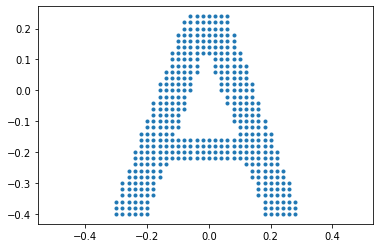

In [ ]:
target_points = gen_points('A')
x, y = target_points.T
pl.plot(x, y, '.');
pl.axis('equal');
len(target_points)

In [ ]:
def RNG(seed):
  key = jax.random.PRNGKey(seed)
  while True:
    key, k1 = jax.random.split(key)
    yield k1

In [ ]:
def resize_1d(a, n):
  idx = jp.int32(jp.linspace(0, a.shape[-1]-1, n)+0.5)
  return a[...,idx]

def sliced_ot(points, target, key, proj_n=32):
  dim_n = points.shape[-1]
  proj = jax.random.normal(key, (dim_n, proj_n))
  proj = proj / jp.sqrt(jp.square(proj).sum(0, keepdims=True))
  proj_points = (points@proj).T.sort() # ([n, dim_n] @ [dim_n, proj_n]).T -> [proj_n, n]
  proj_target = (target@proj).T.sort()
  proj_target = resize_1d(proj_target, len(points))
  return 0.5*jp.square(proj_points-proj_target).sum()/proj_n

  0%|          | 0/50 [00:00<?, ?it/s]

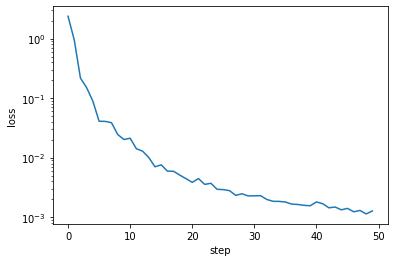

In [ ]:
#@title  { vertical-output: true }

def plot_points(points, target, prev_points=None):
  pl.figure(figsize=(8, 8))
  if prev_points is not None:
    lines = LineCollection(jp.stack([prev_points, points], 1), alpha=0.5)
    pl.gca().add_collection(lines)
  x, y = target.T
  pl.plot(x, y, '.', color='green', alpha=0.2);
  x, y = points.T
  pl.plot(x, y, '.', color='black');
  pl.xlim(-0.5, 0.5)
  pl.ylim(-0.5, 0.5)
  pl.tight_layout()

def run(loss_f):
  rng = RNG(42)
  points = jax.random.normal(next(rng), [500, 2])*0.2
  grad_f = jax.jit(jax.value_and_grad(loss_f))
  log = []
  with VideoWriter(fps=10) as vid:
    plot_points(points, target_points)
    vid.add(grab_plot())  
    for i in trange(50):
      loss, g_points = grad_f(points, target_points, key=next(rng))
      prev_points = points
      points = points-g_points
      log.append(loss)

      plot_points(points, target_points, prev_points)
      vid.add(grab_plot())
      
  pl.plot(log)
  pl.yscale('log');
  pl.xlabel('step')
  pl.ylabel('loss')

run(sliced_ot)

  0%|          | 0/50 [00:00<?, ?it/s]

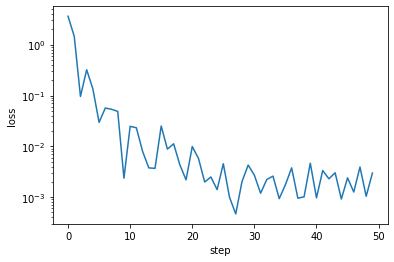

In [ ]:
#@title proj_n=1 { vertical-output: true }
run(partial(sliced_ot, proj_n=1))

  0%|          | 0/50 [00:00<?, ?it/s]

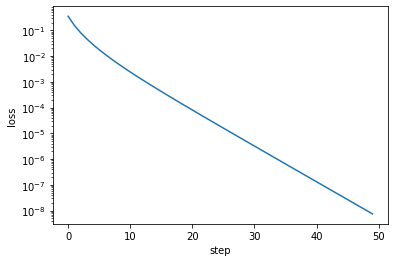

In [ ]:
#@title Gram Matrix matching (for comparison) { vertical-output: true }
def gram_loss(points, target, key=None):
  gram_x = points.T @ points
  gram_y = target.T @ target
  return jp.square(gram_x-gram_y).sum()/len(points)

run(gram_loss)